## Import

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from keras import Input, Model
from keras import activations
from keras.models import load_model
from keras.applications import ResNet50
from keras.layers import Dense, LeakyReLU, Dropout, Concatenate, Lambda
from keras.optimizers import Adam
from keras.utils import plot_model
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping

from sklearn.model_selection import train_test_split
from vis.utils import utils
from vis.utils.utils import find_layer_idx
from vis.visualization import visualize_saliency

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

/home/quoc/anaconda3/envs/py3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Data

In [2]:
batch_size = 10
epochs=50
best_weights = 'weights/best_val.h5'

In [3]:
width, height, depth = 512, 512, 3

train_generator = ImageDataGenerator(
    horizontal_flip=True,
#     vertical_flip=True,
    rotation_range=10,
    zoom_range=0.2,
    fill_mode='wrap',
    validation_split=0.2
)

train_datagen = train_generator.flow_from_directory(
    'data/train/',
    target_size = (width,height),
    class_mode = 'binary',
    batch_size = batch_size,
    subset = 'training',
)

val_datagen = train_generator.flow_from_directory(
    'data/train/',
    target_size = (width,height),
    class_mode = 'binary',
    batch_size = batch_size,
    subset = 'validation',
)

test_generator = ImageDataGenerator(
#     horizontal_flip=True,
#     vertical_flip=True,
#     rotation_range=10,
#     zoom_range=0.2,
#     fill_mode='wrap',
#     validation_split=0.2
)

test_datagen = test_generator.flow_from_directory(
    'data/test',
    target_size=(width, height),
    class_mode = 'binary',
    batch_size = 97,
    shuffle=False)

Found 1917 images belonging to 2 classes.
Found 479 images belonging to 2 classes.
Found 97 images belonging to 2 classes.


## Model

In [4]:
inputs = Input(shape=[width, height, depth])
base_model = ResNet50(input_shape=inputs.shape[1:],
                      input_tensor=inputs,
                      include_top=False,
                      classes=1,
                      pooling='avg'
                      )
x = base_model.output
x = Dense(394)(x)
x = LeakyReLU()(x)
x = Dropout(0.1)(x)
x = Dense(1, activation='sigmoid', kernel_initializer='he_normal')(x)

model = Model(inputs, x)

# plot_model(model, 'single-image-model.png', show_shapes=True)

In [5]:
model.compile(loss='binary_crossentropy',
              optimizer=Adam(lr=0.0001),
              metrics=['accuracy'])

In [6]:
# Optionally load model back
model.load_weights(best_weights)

In [ ]:
for layer in base_model.layers: 
    layer.trainable = False

model.compile(loss='binary_crossentropy',
              optimizer=Adam(lr=0.0001),
              metrics=['accuracy'])

model.fit_generator(
    generator=train_datagen,
    steps_per_epoch=None,
    epochs=5,
    validation_data=val_datagen,
    callbacks=[
#         EarlyStopping(monitor='val_loss',
#                       patience=25,
#                       verbose=1),
        ModelCheckpoint(best_weights,
                        save_best_only=True,
                        save_weights_only=True,
                        monitor='val_loss'),
    ])

In [ ]:
len(train_datagen)

In [ ]:
# unfrezze resnet layers
for layer in base_model.layers:
    layer.trainable = True

model.compile(loss='binary_crossentropy',
              optimizer=Adam(lr=0.0001),
              metrics=['accuracy'])
    
model.fit_generator(
    generator=train_datagen,
    steps_per_epoch=None,
    epochs=20,
    validation_data=val_datagen,
    callbacks=[
    #         EarlyStopping(monitor='val_loss',
    #                       patience=25,
    #                       verbose=1),
    ModelCheckpoint(best_weights,
                    save_best_only=True,
                    save_weights_only=True,
                    monitor='val_loss'),
])

In [ ]:
# Opitionally continue training if needed
# model.load_weights('weights/best_val.h5')
model.fit_generator(
    generator=train_datagen,
    steps_per_epoch=None,
    epochs=10,
    validation_data=val_datagen,
    callbacks=[
    #         EarlyStopping(monitor='val_loss',
    #                       patience=25,
    #                       verbose=1),
    ModelCheckpoint(best_weights,
                    save_best_only=True,
                    save_weights_only=True,
                    monitor='val_loss'),
])

In [ ]:
model.save_weights('weights/best_val.h5')

## Predict

In [9]:
metrics = model.evaluate_generator(test_datagen)
for metric, metric_name in zip(metrics, model.metrics_names):
    print(f"{metric_name}: {metric}")

loss: 0.8622353469767164
acc: 0.7525773291120824


In [ ]:
test_datagen.class_indices

In [10]:
preds = model.predict_generator(test_datagen)
print(f"Preds shape: {preds}")

Preds shape: [[8.29190536e-12]
 [2.00879029e-07]
 [6.53414878e-09]
 [3.20113424e-12]
 [8.71146570e-27]
 [3.09976099e-37]
 [1.93179491e-18]
 [1.99392396e-13]
 [1.15110137e-10]
 [1.41520088e-14]
 [3.92962393e-05]
 [1.00907762e-08]
 [7.95762300e-09]
 [8.34237787e-17]
 [3.06950824e-05]
 [1.42113478e-07]
 [1.30429693e-28]
 [1.28952958e-20]
 [1.47271409e-13]
 [1.31158936e-16]
 [1.38813274e-33]
 [4.69593298e-09]
 [2.66147832e-15]
 [3.07048588e-11]
 [3.91102476e-05]
 [8.08306382e-08]
 [1.53559278e-16]
 [2.58074297e-13]
 [8.83379567e-12]
 [3.37066745e-15]
 [5.19447550e-20]
 [6.90909312e-30]
 [0.00000000e+00]
 [0.00000000e+00]
 [7.51494353e-11]
 [2.52019898e-14]
 [9.12178955e-09]
 [3.31869288e-20]
 [7.35800327e-15]
 [2.42346254e-10]
 [0.00000000e+00]
 [4.22315068e-24]
 [4.60328680e-04]
 [1.50445157e-06]
 [1.23631641e-13]
 [1.30268658e-12]
 [0.00000000e+00]
 [3.92362039e-17]
 [0.00000000e+00]
 [9.74625766e-01]
 [9.81094718e-01]
 [9.83036339e-01]
 [8.61039698e-01]
 [8.38292670e-03]
 [8.90211854e-0

In [11]:
preds_bin = np.round(preds).flatten()
y_test = test_datagen.classes

In [ ]:
preds_bin

## Metrics

In [ ]:
print(f"y_test shape: {y_test.shape}, preds shape: {preds_bin.shape}")

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, preds_bin)
print(f"Confusion matrix:\n{cm}")

In [ ]:
from sklearn.metrics import f1_score
f1 = f1_score(y_test, preds_bin)
print(f"F1 score: {f1}")

In [ ]:
from sklearn.metrics import average_precision_score
aps = average_precision_score(y_test, preds_bin)    
print(f"Average precision score: {aps}")

## Visualize

In [ ]:
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], 2, replace=False)
def rand_by_correct(is_correct): return rand_by_mask((preds_bin == y_test)==is_correct)

In [ ]:
def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        print(ims[i].shape)
        plt.imshow(ims[i])

In [ ]:
def plot_val_with_title(idxs, title):
    imgs = [X_test[x] for x in idxs]
    title_probs = [preds[x] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8))

In [ ]:
plot_val_with_title(rand_by_correct(False), 'yo')

## Attention map

In [ ]:
# Draw Attention Map
layer_idx = find_layer_idx(model, 'dense_2')
model.layers[layer_idx].activation = activations.linear
model = utils.apply_modifications(model)

In [ ]:
i = 21
plt.figure(figsize=(20, 10))
print("ground truth: ", y_test[i])
print("predict: ", preds[i])
grads = visualize_saliency(model, layer_idx, filter_indices=None, seed_input=X_test[i])
# plt.subplot(2, 2, 1)
plt.imshow(X_test[i])
plt.imshow(grads, cmap='jet', alpha=0.5)

In [ ]:
for n in range(X_test.shape[0]):
    plt.figure(figsize=(20,10))
    print("ground truth: ", y_test[n])
    print("predict: ", preds[n])
    grads = visualize_saliency(model, layer_idx, filter_indices=None, seed_input=X_test[n])
#     plt.subplot(1, 2, 1)
    plt.imshow(X_test[n])
    plt.imshow(grads, cmap='jet', alpha=0.7)
#     plt.subplot(1, 2, 2)
#     plt.imshow(X_test[-1 - n])
    plt.show()

Pickup NG images

In [12]:
test_datagen = test_generator.flow_from_directory(
    'data/test',
    target_size=(width, height),
    class_mode = 'binary',
    batch_size = 97,
    shuffle=False)

Found 97 images belonging to 2 classes.


In [13]:
X_test, y_test = next(test_datagen)

In [27]:
preds = model.predict(X_test).flatten()

In [28]:
preds_bin = np.round(preds)

In [38]:
X_test = X_test.astype(np.int)

In [47]:
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], 2, replace=False)
def rand_by_correct(is_correct): return rand_by_mask((preds_bin == y_test)==is_correct)
def plots(ims, figsize=(200, 50), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        print(ims[i].shape)
        plt.imshow(ims[i])

def plot_val_with_title(idxs, title):
    imgs = [X_test[x] for x in idxs]
    title_probs = [preds[x] for x in idxs]
    print(title)
    return plots(imgs, rows=2, titles=title_probs, figsize=(20,12))

def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * preds[idxs])[:14]]

def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask(((preds == y_test)==is_correct) & (y_test == y), mult)

most incorrect NG
(512, 512, 3)
(512, 512, 3)
(512, 512, 3)
(512, 512, 3)
(512, 512, 3)
(512, 512, 3)
(512, 512, 3)
(512, 512, 3)
(512, 512, 3)
(512, 512, 3)
(512, 512, 3)
(512, 512, 3)
(512, 512, 3)
(512, 512, 3)


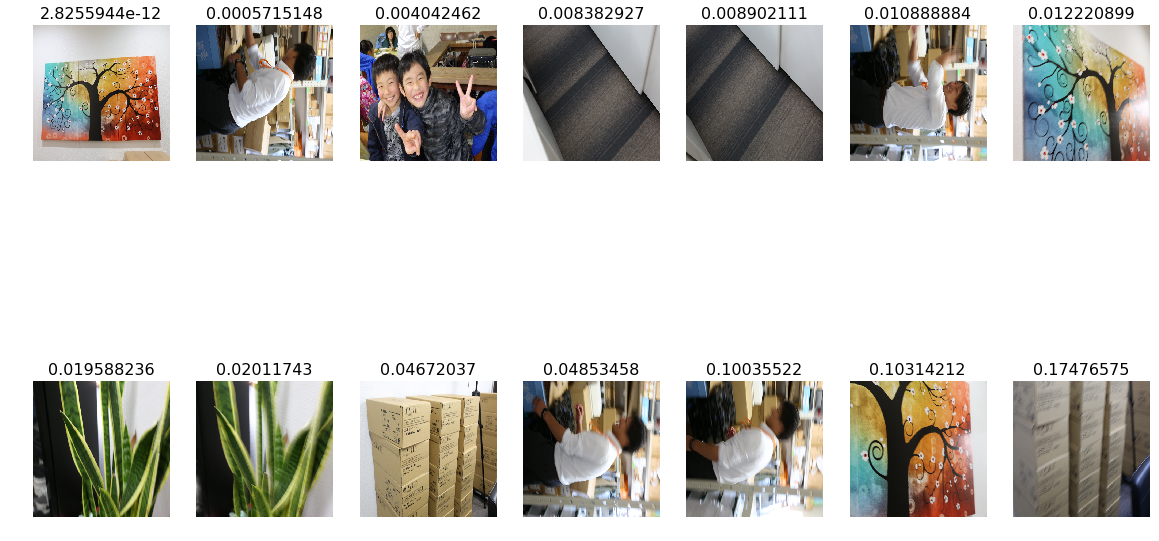

In [48]:
# plot_val_with_title(rand_by_correct(False), 'Predict wrong')
plot_val_with_title(most_by_correct(1, False), "most incorrect NG")


In [42]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, preds_bin)
print(f"Confusion matrix:\n{cm}")

Confusion matrix:
[[49  0]
 [24 24]]
